In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re

In [2]:
DATA_FOLDER = 'data'

In [3]:
dinner_nutrients_df = pd.read_csv('dinner_nutrient.csv')
dinner_ingredients_df = pd.read_csv('dinner_ingredient.csv')

brunch_nutrients_first = pd.read_csv('brunch_nutrient_1-120.csv')
brunch_nutrients_next = pd.read_csv('brunch_nutrient_121-524.csv')
brunch_ingredients_first = pd.read_csv('brunch_ingredient_1-120.csv')
brunch_ingredients_next = pd.read_csv('brunch_ingredient_121-524.csv')

vege_nutrients_df = pd.read_csv('vegetarian_nutrient.csv')
vege_ingredients_df = pd.read_csv('vegetarian_ingredient.csv')

In [4]:
daily_values = pd.read_csv('data/DailyValues', sep=':', header=None, names=['nutrient', 'unit', 'amount'])

## What we need to do

**Cleaning:**
1. Make quantities of nutrients into integers (while respecting units)

**Analysis:**
1. Plot histograms of the quantity of a given nutrient thoughout the vegetarian recipes
2. Calculate median and mode (= most common value)
3. Compare these with the FDA recommendation. NOTE this needs to be per serving
4. Calculate median and mode from omnivorous dataset. For large differences with the vegetarian data, also view histogram. Compare together and with FDA.
5. For vegetarian histograms with large discrepencies (some recipes with high levels of nutrient, others with low levels), cross-reference ingredients to see what may be responsible for providing the nutrient.

**Visualization of results:**
1. It would be good to plot the FDA recommendation on the histogram, also median and mode

### Lets explore the data and do some cleaning

In [5]:
dinner_nutrients_df.head(20)

,Unnamed: 0,URL,amount,nutrient,recipe
0,0,https://www.allrecipes.com/recipe/222607/smoth...,20.1g,Total Fat,Smothered Chicken Breasts
1,1,https://www.allrecipes.com/recipe/222607/smoth...,8.0g,Saturated Fat,Smothered Chicken Breasts
2,2,https://www.allrecipes.com/recipe/222607/smoth...,124mg,Cholesterol,Smothered Chicken Breasts
3,3,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
4,4,https://www.allrecipes.com/recipe/222607/smoth...,377mg,Potassium,Smothered Chicken Breasts
5,5,https://www.allrecipes.com/recipe/222607/smoth...,16.9g,Total Carbohydrates,Smothered Chicken Breasts
6,6,https://www.allrecipes.com/recipe/222607/smoth...,0.5g,Dietary Fiber,Smothered Chicken Breasts
7,7,https://www.allrecipes.com/recipe/222607/smoth...,44g,Protein,Smothered Chicken Breasts
8,8,https://www.allrecipes.com/recipe/222607/smoth...,15g,Sugars,Smothered Chicken Breasts
9,9,https://www.allrecipes.com/recipe/222607/smoth...,29IU,Vitamin A,Smothered Chicken Breasts


We wonder if the amounts for each nutrient always have the same units. Lets verify with Sodium since this is likely to vary a lot. Below only 'head' is displayed, but we checked throughout the dataset.

In [6]:
dinner_nutrients_df = dinner_nutrients_df.drop(["Unnamed: 0"], axis=1)
dinner_ingredients_df = dinner_ingredients_df.drop(["Unnamed: 0"], axis=1)

In [7]:
sodium = dinner_nutrients_df.where(dinner_nutrients_df['nutrient'] == "Sodium")
sodium = sodium.dropna()
sodium = sodium.reset_index(drop=True)
sodium.head()

,URL,amount,nutrient,recipe
0,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
1,https://www.allrecipes.com/recipe/15679/asian-...,711mg,Sodium,Asian Beef with Snow Peas
2,https://www.allrecipes.com/recipe/23847/pasta-...,350mg,Sodium,Pasta Pomodoro
3,https://www.allrecipes.com/recipe/50435/fry-br...,2255mg,Sodium,Fry Bread Tacos II
4,https://www.allrecipes.com/recipe/140829/pork-...,356mg,Sodium,Pork Marsala


The unit is the same for each value of a given nutrient, therefore we can drop these letters without worry.

Vitamin A will be completely ignored since it is given in IU. This unit will no longer be valid from 2021. In addition, it cannot be converted into micrograms since this depends on its origin: retinol (pre-formed vitamin A) or beta-carotene (a precursor).

In [8]:
dinner_nutrients_df = dinner_nutrients_df[dinner_nutrients_df.nutrient != "Vitamin A"]

In [9]:
dinner_nutrients_df.head()

,URL,amount,nutrient,recipe
0,https://www.allrecipes.com/recipe/222607/smoth...,20.1g,Total Fat,Smothered Chicken Breasts
1,https://www.allrecipes.com/recipe/222607/smoth...,8.0g,Saturated Fat,Smothered Chicken Breasts
2,https://www.allrecipes.com/recipe/222607/smoth...,124mg,Cholesterol,Smothered Chicken Breasts
3,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
4,https://www.allrecipes.com/recipe/222607/smoth...,377mg,Potassium,Smothered Chicken Breasts


In [10]:
#Remove the letters m, c, g, I, U from the string amount and convert it to a float
dinner_nutrients_df.amount = dinner_nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
dinner_nutrients_df.amount = dinner_nutrients_df.amount.replace(to_replace='< 1', value='0')
dinner_nutrients_df.amount = dinner_nutrients_df.amount.astype(float)
dinner_nutrients_df.dtypes

URL          object
amount      float64
nutrient     object
recipe       object
dtype: object

Now lets simplify the datasets

In [11]:
#We can identify recipes by their ID
recipe_id = dinner_ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_ingredients_df["recipe_id"] = recipe_id
dinner_ingredients_df = dinner_ingredients_df.drop(["URL"], axis=1)
dinner_ingredients_df.head()

,ingredient,recipe_id
0,"4 (6 ounce) skinless, boneless chicken breast ...",222607
1,1/4 teaspoon salt,222607
2,1/4 teaspoon lemon pepper seasoning,222607
3,1 tablespoon vegetable oil,222607
4,8 strips bacon,222607


In [12]:
print("We have: " + str(len(dinner_ingredients_df["recipe_id"].unique())) + " recipes in the ingredient dataframe.")

We have: 1152 recipes in the ingredient dataframe.


In [13]:
recipe_id = dinner_nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_nutrients_df["recipe_id"] = recipe_id
dinner_nutrients_df.head()

,URL,amount,nutrient,recipe,recipe_id
0,https://www.allrecipes.com/recipe/222607/smoth...,20.1,Total Fat,Smothered Chicken Breasts,222607
1,https://www.allrecipes.com/recipe/222607/smoth...,8.0,Saturated Fat,Smothered Chicken Breasts,222607
2,https://www.allrecipes.com/recipe/222607/smoth...,124.0,Cholesterol,Smothered Chicken Breasts,222607
3,https://www.allrecipes.com/recipe/222607/smoth...,809.0,Sodium,Smothered Chicken Breasts,222607
4,https://www.allrecipes.com/recipe/222607/smoth...,377.0,Potassium,Smothered Chicken Breasts,222607


In [14]:
# let's create a dataframe that contain all the different recipes for dinner with the corresponding name
dinner_recipe_df = dinner_nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
dinner_recipe_df = dinner_recipe_df.set_index("recipe_id")
print("We have in total: " + str(dinner_recipe_df["recipe"].count()) + " different recipes with nutrition info\
      for dinner")
dinner_recipe_df.head()

We have in total: 1128 different recipes with nutrition info      for dinner


,recipe,URL
recipe_id,,
222607,Smothered Chicken Breasts,https://www.allrecipes.com/recipe/222607/smoth...
15679,Asian Beef with Snow Peas,https://www.allrecipes.com/recipe/15679/asian-...
23847,Pasta Pomodoro,https://www.allrecipes.com/recipe/23847/pasta-...
50435,Fry Bread Tacos II,https://www.allrecipes.com/recipe/50435/fry-br...
140829,Pork Marsala,https://www.allrecipes.com/recipe/140829/pork-...


In [15]:
dinner_nutrients_df = dinner_nutrients_df.drop(["URL", "recipe"], axis=1)
dinner_nutrients_df.head()

,amount,nutrient,recipe_id
0,20.1,Total Fat,222607
1,8.0,Saturated Fat,222607
2,124.0,Cholesterol,222607
3,809.0,Sodium,222607
4,377.0,Potassium,222607


We see that there are recipes that did not give the nutrient values. We ignore these ones by putting exclusively recipe IDs present in the nutrient dataframe into the dataframe linking recipes with URL and name.

**Now we can clean our other datasets easily **

In [16]:
def clean_data(nutrients_df, ingredients_df):
    """
    After exploration, we create a general function to clean all subsequent datasets
    IN: nutrient and ingredient information, in dataframes
    OUT: cleaned nutrient and ingredient dataframes + a new dataframe linking the URL, ID, and name of recipes
    """
    
    nutrients_df = nutrients_df.drop(["Unnamed: 0"], axis=1)
    ingredients_df = ingredients_df.drop(["Unnamed: 0"], axis=1)
    
    #Drop vitamin A
    nutrients_df = nutrients_df[nutrients_df.nutrient != "Vitamin A"]
    
    #Remove the letters m, c, g, I, U from the string amount and convert it to a float
    nutrients_df.amount = nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
    nutrients_df.amount = nutrients_df.amount.replace(to_replace='< 1', value='0')
    nutrients_df.amount = nutrients_df.amount.astype(float)
    
    #Identification with ID
    recipe_id = ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    ingredients_df["recipe_id"] = recipe_id
    ingredients_df = ingredients_df.drop(["URL"], axis=1)
    
    recipe_id = nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    nutrients_df["recipe_id"] = recipe_id
    
    #Dataframe linking ID with URL and recipe name
    recipe_df = nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
    recipe_df = recipe_df.set_index("recipe_id")
    
    nutrients_df = nutrients_df.drop(["URL", "recipe"], axis=1)
    
    return nutrients_df, ingredients_df, recipe_df

In [17]:
brunch_nutrients_df = brunch_nutrients_first.append(brunch_nutrients_next)
brunch_ingredients_df = brunch_ingredients_first.append(brunch_ingredients_next)
brunch_recipes = []

In [18]:
brunch_nutrients_df, brunch_ingredients_df, brunch_recipes = clean_data(brunch_nutrients_df, brunch_ingredients_df)

In [19]:
vege_recipes = []
vege_nutrients_df, vege_ingredients_df, vege_recipes = clean_data(vege_nutrients_df, vege_ingredients_df)

We remember that the recommended intake for each nutrient is given per day. We suppose a serving of food to correspond to 1/3 of this value. This is deemed acceptable since we are not dealing with small quantitites of food such as snacks, appetizers, or desserts. It is reasonable to assume three major meals through the day.

In [20]:
daily_values.amount = daily_values.amount / 3

### Nutrient histograms for vegetarian meals

**Testing making "brunch" data vegetarian:**

If an ingredient contains any word from the document "meats", delete all nutrients with the corresponding ID

In [21]:
f = open('data/meats', 'r')
meat = f.read().splitlines()
f.close()

In [22]:
brunch_copy = brunch_ingredients_df.copy()
brunch_copy = brunch_copy.merge(brunch_recipes, left_on='recipe_id', right_index=True, how='inner', sort=False)

In [23]:
id_to_delete = pd.DataFrame(columns=['URL', 'ingredient', 'recipe', 'recipe_id'])

for i in range(len(meat)):
    id_to_delete = id_to_delete.append(brunch_copy[brunch_copy['ingredient'].str.contains(meat[i])], sort=False)

In [24]:
id_to_delete.head()

,URL,ingredient,recipe,recipe_id
303,https://www.allrecipes.com/recipe/22162/uglies/,1 pound ground beef chuck,Uglies,22162
755,https://www.allrecipes.com/recipe/33129/corned...,"1 (12 ounce) can corned beef, cut into chunks",Corned Beef Hash,33129
757,https://www.allrecipes.com/recipe/33129/corned...,1 cup beef broth,Corned Beef Hash,33129
1567,https://www.allrecipes.com/recipe/216981/delux...,"2 pounds cooked corned beef, cubed",Deluxe Corned Beef Hash,216981
2702,https://www.allrecipes.com/recipe/45652/the-sa...,2 pounds ground beef,The Sarge's Goetta - German Breakfast Treat,45652


In [25]:
brunch_nutrient_copy = brunch_nutrients_df.copy()
brunch_nutrient_copy=brunch_nutrient_copy[~brunch_nutrient_copy.isin(id_to_delete['recipe_id'].tolist())]

In [26]:
#Test that the above function worked correctly:

In [27]:
test = brunch_nutrient_copy.where(brunch_nutrient_copy['recipe_id'] == '33129')
test = test.dropna()
test.head(1)

,amount,nutrient,recipe_id


In [28]:
nutrient_copy = brunch_nutrients_df.merge(brunch_recipes, how='inner', left_on='recipe_id', right_index=True)

In [29]:
val = nutrient_copy.where(nutrient_copy['recipe_id'] == '33129')
val = val.dropna()
val.head(1)

,amount,nutrient,recipe_id,recipe,URL
1440,8.8,Total Fat,33129,Corned Beef Hash,https://www.allrecipes.com/recipe/33129/corned...


**From these insights we make a generalized function**

In [30]:
def vegetarianize(nutrients_df, ingredients_df, recipes_df, filename):
    """
    For all words listed in the file, if that word is contained in ingredients_df,
    the corresponding recipe is deleted from nutrients_df
    IN: ingredients, nutrients, and recipes, also the name of the file
    OUT: nutrients from vegetarian recipes
    """
    
    f = open(filename, 'r')
    file = f.read().splitlines()
    f.close()
    
    #inner merge ingredients with recipes to associate them with recipe IDs that have nutrients
    ingredients_copy = ingredients_df.copy()
    ingredients_copy = ingredients_copy.merge(recipes_df, left_on='recipe_id', right_index=True, 
                                              how='inner', sort=False)
    
    #Create a dataframe of IDs to delete, corresponding to recipes that contain meat
    id_to_delete = pd.DataFrame(columns=['URL', 'ingredient', 'recipe', 'recipe_id'])
    for i in range(len(file)):
        id_to_delete = id_to_delete.append(ingredients_copy[ingredients_copy['ingredient'].str
                                                            .contains(meat[i])], sort=False)
    
    #The vegetarian recipes are those not listed in id_to_delete; we keep their nutrients
    nutrients_copy = nutrients_df.copy()
    nutrients_copy=nutrients_copy[~nutrients_copy.isin(id_to_delete['recipe_id'].tolist())]
    
    return nutrients_copy

In [32]:
temporary_vege_brunch_nutrients = vegetarianize(brunch_nutrients_df, brunch_ingredients_df, brunch_recipes,
                                     filename = 'data/meats')
vege_brunch_nutrients = vegetarianize(temporary_vege_brunch_nutrients, brunch_ingredients_df, brunch_recipes,
                                     filename = 'data/fish' )
vege_brunch_nutrients.head()

,amount,nutrient,recipe_id
0,6.4,Total Fat,7016
1,2.0,Saturated Fat,7016
2,128.0,Cholesterol,7016
3,478.0,Sodium,7016
4,190.0,Potassium,7016


In [33]:
brunch_recipes.loc['7016']

recipe                                       French Toast I
URL       https://www.allrecipes.com/recipe/7016/french-...
Name: 7016, dtype: object

**Now lets put all the nutrients from vegetarian meals together, and make histograms**

In [34]:
def nutrient_histogram(nutrients_df, name):
    
    """
    Plot a histogram with the amount for a specified nutrient. Show median (black) and FDA recommendation (red).
    IN: nutrient dataframe and name of the nutrient we want to plot
    OUT: histogram with 20 bins for 'amount', median and recommended amounts for the nutrient
    """
    nutrient = nutrients_df.where(nutrients_df['nutrient'] == name)
    nutrient = nutrient.dropna()
    nutrient = nutrient.reset_index(drop=True)
    
    recommended = daily_values.where(daily_values['nutrient'] == name)
    recommended = recommended.dropna()
    recommended = recommended.reset_index(drop=True)
    
    median = nutrient.amount.median()
    rec_value = recommended.at[0, 'amount']

    graph = nutrient.hist(column='amount', bins=50);
    plt.title(n)
    plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(rec_value, color='r', linestyle='dashed', linewidth=1)
        
    return median, rec_value, graph

In [35]:
vege_nutrient_merge = vege_nutrients_df.append(vege_brunch_nutrients, ignore_index=True, sort=False)

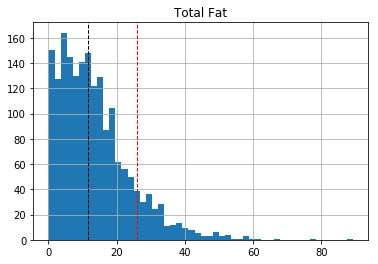

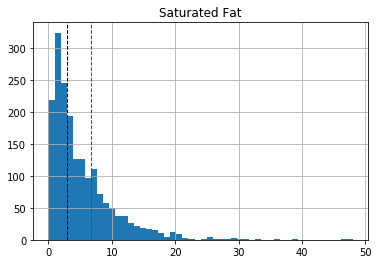

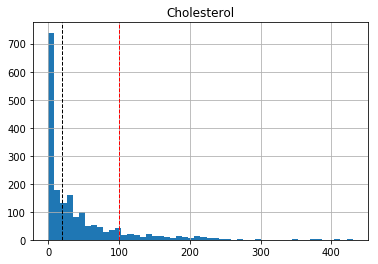

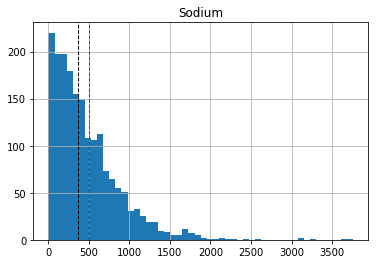

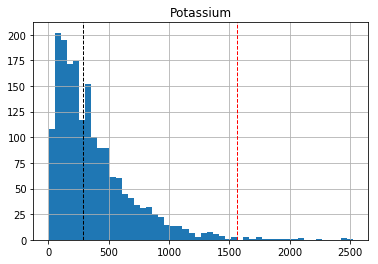

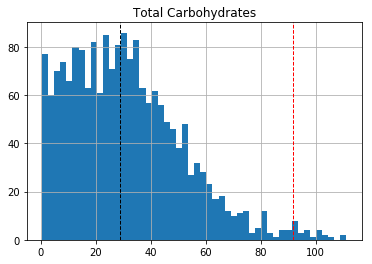

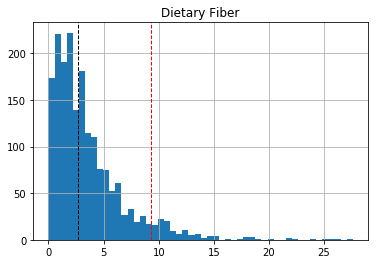

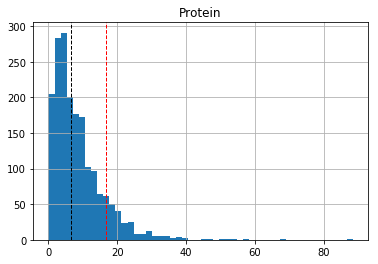

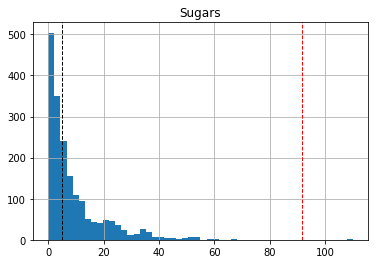

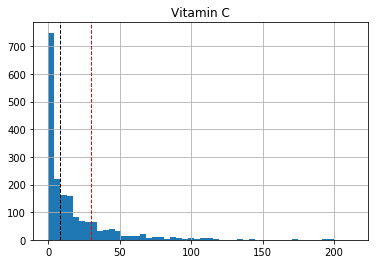

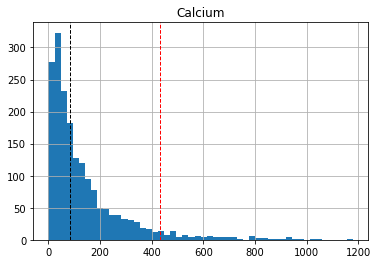

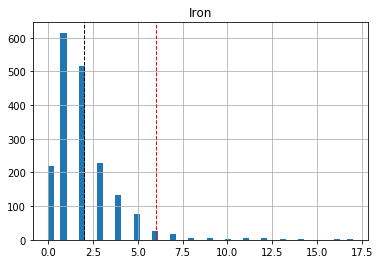

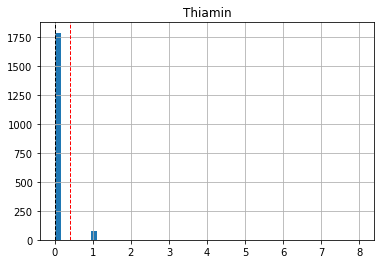

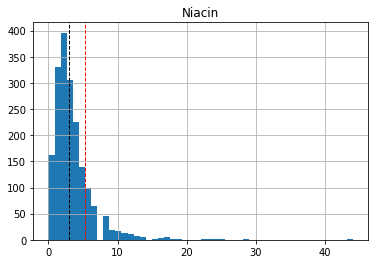

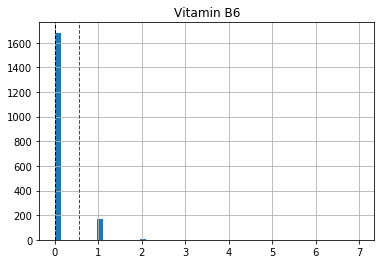

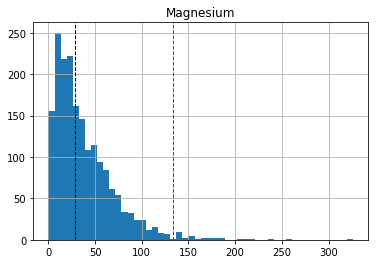

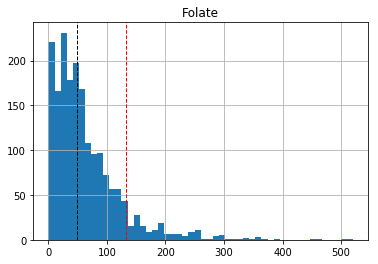

In [36]:
nutrient_list = vege_nutrient_merge['nutrient'].unique()
compare_values = pd.DataFrame(columns=['nutrient', 'median', 'rec_value'])

for n in nutrient_list:
    median, rec_value, toto = nutrient_histogram(vege_nutrient_merge, n);
    compare_values = compare_values.append({'nutrient': n, 'median':median, 'rec_value': rec_value}, 
                                           ignore_index=True)

In [37]:
compare_values

,nutrient,median,rec_value
0,Total Fat,11.6,26.000000
1,Saturated Fat,3.0,6.666667
2,Cholesterol,19.0,100.000000
3,Sodium,367.0,500.000000
4,Potassium,287.0,1566.666667
5,Total Carbohydrates,28.8,91.666667
6,Dietary Fiber,2.7,9.333333
7,Protein,6.7,16.666667
8,Sugars,5.0,91.666667
9,Vitamin C,8.0,30.000000
